# Lab 4
## Nick Friesen & Tim Ufer

In [1]:
import math
import time

import numba
import numpy as np
from numpy.matlib import repmat
import torchvision
from torchvision.transforms import transforms

from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

In [2]:
# Improved version by Kristofer Ågren
@numba.njit(fastmath=True)
def getEuclideanDistance(single_point, array):
    nrows, ncols, nfeatures = array.shape[0], array.shape[1], array.shape[2]
    points = array.reshape((nrows * ncols, nfeatures))
    dist = np.empty(points.shape[0], dtype=single_point.dtype)

    for m in range(points.shape[0]):
        s = 0
        for n in range(single_point.shape[0]):
            s += (points[m, n] - single_point[n]) ** 2
        dist[m] = math.sqrt(s)

    dist = dist.reshape((nrows, ncols))

    return dist

In [3]:
def SOM(dispRes, trainingData, ndim=10, nepochs=10, eta0=0.1, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0):
    nfeatures = trainingData.shape[1]
    ntrainingvectors = trainingData.shape[0]

    nrows = ndim
    ncols = ndim

    mu, sigma = 0, 0.1
    np.random.seed(int(time.time()))
    som = np.random.normal(mu, sigma, (nrows, ncols, nfeatures))

    if showMode == 1:
        print("\nSOM features before training: \n")

        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

        for k in range(nrows):
            for l in range(ncols):
                A = som[k, l, :].reshape((dispRes[0], dispRes[1]))
                ax[k, l].imshow(A, cmap="plasma")
                ax[k, l].set_yticks([])
                ax[k, l].set_xticks([])
        plt.show()

    #Generate coordinate system
    x, y = np.meshgrid(range(ncols), range(nrows))

    for t in range(1, nepochs + 1):
        # Show intermediate weights
        if showMode == 1 and t == (nepochs // 2) + 1:
            print("\nSOM features at 50% training: \n")

            fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

            for k in range(nrows):
                for l in range(ncols):
                    A = som[k, l, :].reshape((dispRes[0], dispRes[1]))
                    ax[k, l].imshow(A, cmap="plasma")
                    ax[k, l].set_yticks([])
                    ax[k, l].set_xticks([])
            plt.show()

        #Compute the learning rate for the current epoch
        eta = eta0 * math.exp(-t * etadecay)

        #Compute the variance of the Gaussian (Neighbourhood) function for the ucrrent epoch
        sgm = sgm0 * math.exp(-t * sgmdecay)

        #Consider the width of the Gaussian function as 3 sigma
        width = math.ceil(sgm * 3)

        for ntraining in range(ntrainingvectors):
            trainingVector = trainingData[ntraining, :]

            # Compute the Euclidean distance between the training vector and
            # each neuron in the SOM map
            dist = getEuclideanDistance(trainingVector, som)

            # Find 2D coordinates of the Best Matching Unit (bmu)
            bmurow, bmucol = np.unravel_index(np.argmin(dist, axis=None), dist.shape)

            #Generate a Gaussian function centered on the location of the bmu
            g = np.exp(-((np.power(x - bmucol, 2)) + (np.power(y - bmurow, 2))) / (2 * sgm * sgm))

            #Determine the boundary of the local neighbourhood
            fromrow = max(0, bmurow - width)
            torow = min(bmurow + width, nrows)
            fromcol = max(0, bmucol - width)
            tocol = min(bmucol + width, ncols)

            #Get the neighbouring neurons and determine the size of the neighbourhood
            neighbourNeurons = som[fromrow:torow, fromcol:tocol, :]
            sz = neighbourNeurons.shape

            #Transform the training vector and the Gaussian function into 
            # multidimensional to facilitate the computation of the neuron weights update
            T = np.matlib.repmat(trainingVector, sz[0] * sz[1], 1).reshape((sz[0], sz[1], nfeatures))
            # G = np.dstack([g[fromrow:torow, fromcol:tocol]] * nfeatures)
            gg = g[fromrow:torow, fromcol:tocol]
            G = np.repeat(gg, nfeatures).reshape((gg.shape[0], gg.shape[1], nfeatures))
            # Update the weights of the neurons that are in the neighbourhood of the bmu
            neighbourNeurons = neighbourNeurons + eta * G * (T - neighbourNeurons)

            #Put the new weights of the BMU neighbouring neurons back to the
            #entire SOM map
            som[fromrow:torow, fromcol:tocol, :] = neighbourNeurons

        if showMode >= 1:
            print(f"Training epoch {t} completed")

    if showMode == 1:
        print("\nSOM features AFTER training: \n")

        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

        for k in range(nrows):
            for l in range(ncols):
                A = som[k, l, :].reshape((dispRes[0], dispRes[1]))
                ax[k, l].imshow(A, cmap="plasma")
                ax[k, l].set_yticks([])
                ax[k, l].set_xticks([])
        plt.show()
    return som

In [4]:
#verification of correctness on the training set:
def SOM_Test(trainingData, som_, classes, grid_, ConfusionMatrix, ndim=60):
    nfeatures = trainingData.shape[1]
    ntrainingvectors = trainingData.shape[0]

    nrows = ndim
    ncols = ndim

    nclasses = np.max(classes)

    som_cl = np.zeros((ndim, ndim, nclasses + 1))

    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining, :]
        class_of_sample = classes[ntraining]
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_)

        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol = np.unravel_index(np.argmin(dist, axis=None), dist.shape)

        som_cl[bmurow, bmucol, class_of_sample] = som_cl[bmurow, bmucol, class_of_sample] + 1

    for i in range(nrows):
        for j in range(ncols):
            grid_[i, j] = np.argmax(som_cl[i, j, :])

    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining, :]
        class_of_sample = classes[ntraining]
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_)

        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol = np.unravel_index(np.argmin(dist, axis=None), dist.shape)

        predicted = np.argmax(som_cl[bmurow, bmucol, :])
        ConfusionMatrix[class_of_sample - 1, predicted - 1] = ConfusionMatrix[class_of_sample - 1, predicted - 1] + 1

    return grid_, ConfusionMatrix

# CIFAR-10
### Step 1: Loading the data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(0.5, 0.5)])

trainset = torchvision.datasets.CIFAR10(root='./data/project/cifar', train=True, download=True, transform=transform)
train_X_rgb = trainset.data
train_X = np.empty((train_X_rgb.shape[0], train_X_rgb.shape[1], train_X_rgb.shape[2]))
for i in range(len(train_X)):
    train_X[i] = transform(train_X_rgb[i]).numpy()[0]
train_y = trainset.targets

testset = torchvision.datasets.CIFAR10(root='./data/project/cifar', train=False, download=True, transform=transform)
test_X_rgb = testset.data
test_X = np.empty((test_X_rgb.shape[0], test_X_rgb.shape[1], test_X_rgb.shape[2]))
for i in range(len(test_X)):
    test_X[i] = transform(test_X_rgb[i]).numpy()[0]
test_y = testset.targets

disp_res = train_X.shape[1]

Files already downloaded and verified
Files already downloaded and verified


(32, 32)


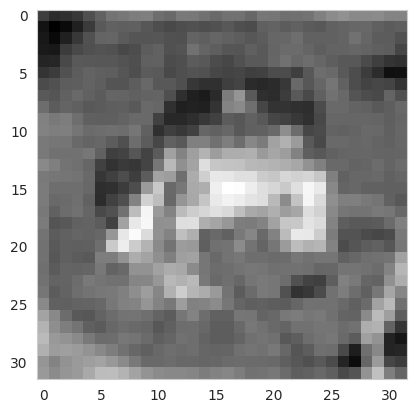

In [6]:
print(train_X[0].shape)
plt.imshow(train_X[0], cmap='gray')
plt.show()

In [7]:
print(train_X.shape)

(50000, 32, 32)


### Step 2: Flattening the data

In [8]:
# Create flattened version of mnist train data
train_X_flat = np.empty([train_X.shape[0], train_X.shape[1] * train_X.shape[2]])
for idx in range(train_X.shape[0]):
    train_X_flat[idx] = train_X[idx].flatten()
    
test_X_flat = np.empty([test_X.shape[0], test_X.shape[1] * test_X.shape[2]])
for idx in range(test_X.shape[0]):
    test_X_flat[idx] = test_X[idx].flatten()

print(train_X_flat.shape, test_X_flat.shape)

(50000, 1024) (10000, 1024)


### Step 3: Training the SOM with various hyperparameters
To reduce training time, only a subset of the full 50000 CIFAR images are used. Separate, equally sized subsets are used for training and validation. Different parameter values are tested for 5 epochs at a time and the performance is measured in the F1-score. 

In [9]:
def metrics(conf_mat, macro_avg=True):
    tp = np.diag(conf_mat)
    fp = np.sum(conf_mat, axis=0) - tp
    fn = np.sum(conf_mat, axis=1) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    if not macro_avg:
        return f1, precision, recall
    return np.mean(f1), np.mean(precision), np.mean(recall)

In [10]:
def param_finder(params_dict, n_samples=1000, n_epochs=5):
    classes = train_y[:n_samples]
    nclasses = len(trainset.classes)
    chosen_params = {}

    print(f"Testing values {params_dict['ndim']} for parameter ndim")
    top_f1 = 0
    for ndim in params_dict['ndim']:
        som = SOM([disp_res, disp_res], train_X_flat[:n_samples], ndim=ndim, nepochs=n_epochs)
        grid_color = np.zeros((ndim, ndim))
        Confusion_Matrix = np.zeros((nclasses, nclasses))
        grid_color, Confusion_Matrix = SOM_Test(train_X_flat[n_samples:n_samples*2], som, classes, grid_color, Confusion_Matrix, ndim)
        f1, _, _ = metrics(Confusion_Matrix)
        print(f"ndim={ndim}: f1={f1}")
        if f1 > top_f1:
            chosen_params['ndim'] = ndim
            top_f1 = f1
    print(f"Final ndim value is {chosen_params['ndim']} with f1={top_f1}\n")

    print(f"Testing values {params_dict['eta0']} for parameter eta0")
    top_f1 = 0
    for eta0 in params_dict['eta0']:
        som = SOM([disp_res, disp_res], train_X_flat[:n_samples], ndim=chosen_params['ndim'], eta0=eta0, nepochs=n_epochs)
        grid_color = np.zeros((chosen_params['ndim'], chosen_params['ndim']))
        Confusion_Matrix = np.zeros((nclasses, nclasses))
        grid_color, Confusion_Matrix = SOM_Test(train_X_flat[n_samples:n_samples*2], som, classes, grid_color, Confusion_Matrix, chosen_params['ndim'])
        f1, _, _ = metrics(Confusion_Matrix)
        print(f"eta0={eta0}: f1={f1}")
        if f1 > top_f1:
            chosen_params['eta0'] = eta0
            top_f1 = f1
    print(f"Final eta0 value is {chosen_params['eta0']} with f1={top_f1}\n")

    print(f"Testing values {params_dict['etadecay']} for parameter etadecay")
    top_f1 = 0
    for etadecay in params_dict['etadecay']:
        som = SOM([disp_res, disp_res], train_X_flat[:n_samples], ndim=chosen_params['ndim'], eta0=chosen_params['eta0'], etadecay=etadecay,
                  nepochs=n_epochs)
        grid_color = np.zeros((chosen_params['ndim'], chosen_params['ndim']))
        Confusion_Matrix = np.zeros((nclasses, nclasses))
        grid_color, Confusion_Matrix = SOM_Test(train_X_flat[n_samples:n_samples*2], som, classes, grid_color, Confusion_Matrix, chosen_params['ndim'])
        f1, _, _ = metrics(Confusion_Matrix)
        print(f"etadecay={etadecay}: f1={f1}")
        if f1 > top_f1:
            chosen_params['etadecay'] = etadecay
            top_f1 = f1
    print(f"Final etadecay value is {chosen_params['etadecay']} with f1={top_f1}")

    return chosen_params

In [11]:
params = {
    'ndim': [20,40,80],
    'eta0': [0.1,0.05,0.01,0.005],
    'etadecay': [0.1, 0.075, 0.05, 0.03, 0.01]
}

param_results = param_finder(params)
print(param_results)

Testing values [20, 40, 80] for parameter ndim
ndim=20: f1=0.2431821058191945
ndim=40: f1=0.47845989841508746
ndim=80: f1=0.753174085987736
Final ndim value is 80 with f1=0.753174085987736

Testing values [0.1, 0.05, 0.01, 0.005] for parameter eta0
eta0=0.1: f1=0.7301320213460504
eta0=0.05: f1=0.7214748514169169
eta0=0.01: f1=0.717329559809812
eta0=0.005: f1=0.7586284423095943
Final eta0 value is 0.005 with f1=0.7586284423095943

Testing values [0.1, 0.075, 0.05, 0.03, 0.01] for parameter etadecay
etadecay=0.1: f1=0.7647281757950085
etadecay=0.075: f1=0.7275307125202923
etadecay=0.05: f1=0.7585132345028155
etadecay=0.03: f1=0.7355900296036535
etadecay=0.01: f1=0.7342076757674499
Final etadecay value is 0.1 with f1=0.7647281757950085
{'ndim': 80, 'eta0': 0.005, 'etadecay': 0.1}


### Step 4: Full training run

In [13]:
ndim = param_results['ndim']
eta0 = param_results['eta0']
etadecay = param_results['etadecay']
# Final SOM
num_samples = 10000
som_cifar = SOM([disp_res, disp_res], train_X_flat[:num_samples], ndim=ndim, nepochs=10, eta0=eta0, etadecay=etadecay, showMode=2)

Training epoch 1 completed
Training epoch 2 completed
Training epoch 3 completed
Training epoch 4 completed
Training epoch 5 completed
Training epoch 6 completed
Training epoch 7 completed
Training epoch 8 completed
Training epoch 9 completed
Training epoch 10 completed


#### Training set results

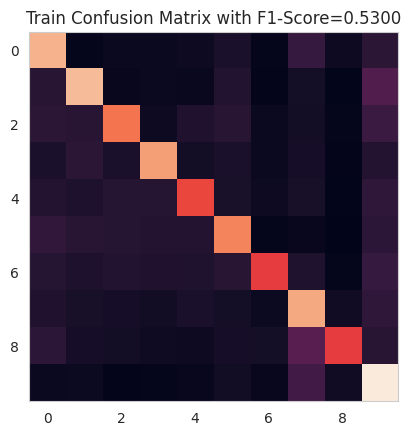

In [37]:
classes = train_y[:num_samples]
nclasses = len(trainset.classes)
grid_color = np.zeros((ndim, ndim))

Confusion_Matrix = np.zeros((nclasses, nclasses))
grid_color, Confusion_Matrix = SOM_Test(train_X_flat[:num_samples], som_cifar, classes, grid_color, Confusion_Matrix, ndim)
f1, _, _ = metrics(Confusion_Matrix)

plt.imshow(Confusion_Matrix)
plt.title(f"Train Confusion Matrix with F1-Score={f1:.4f}")
plt.show()

### Step 5: Classification
#### Test set results

In [38]:
classes = test_y
nclasses = len(trainset.classes)
grid_color = np.zeros((ndim, ndim))

Confusion_Matrix = np.zeros((nclasses, nclasses))
grid_color, Confusion_Matrix = SOM_Test(test_X_flat, som_cifar, classes, grid_color, Confusion_Matrix, ndim)
f1, precision, recall = metrics(Confusion_Matrix)
acc = np.sum(np.diag(Confusion_Matrix)) / np.sum(Confusion_Matrix)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.5313458597890574 0.5563234187710937 0.5332999999999999 0.5333


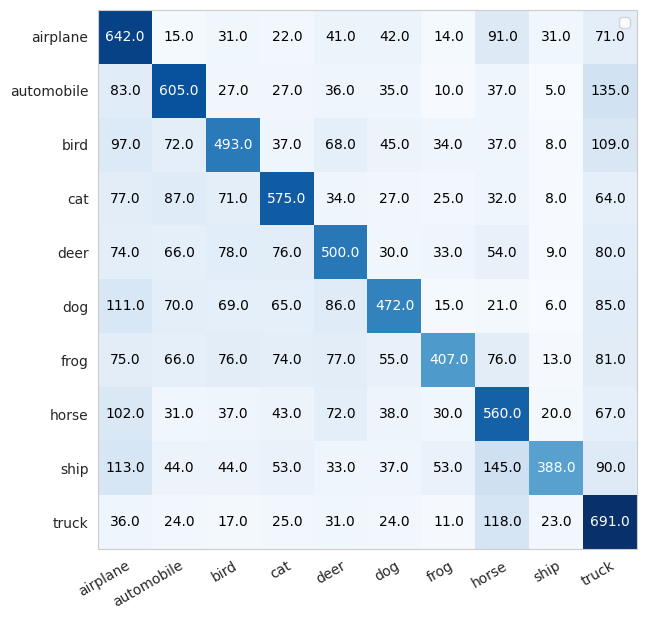

In [44]:
print(f1,precision,recall, acc)
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(Confusion_Matrix, cmap='Blues')
# plt.title(f"Test Confusion Matrix with F1-Score={f1:.4f}")
plt.xticks(np.arange(10), trainset.classes)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(10), trainset.classes)

for i in range(10):
    for j in range(10):
        if i == j:
            ax.text(j, i, Confusion_Matrix[i, j], ha="center", va="center", color="w")
        else:
            ax.text(j, i, Confusion_Matrix[i, j], ha="center", va="center", color="k")
plt.show()